In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import cmath

# Définition des paramètres

In [2]:
# Définir les constantes et paramètres du modèle
a = 0.1e-6# m
epsilon_r = 80.0
epsilon_0 = 8.85e-12
mu = 5e-8
n_1 = 1.0
n_3 = 0.12 * n_1
n_2= 0.88*n_1
T = 293.0  # K
E_0 = 1.0
K = 1.380649e-23
# omega = 3e8 
# omega = 3e4 # rad/s
e = 1.602e-19
#F = 6.0221e23*e
alpha = 1e-10
beta = 1e-2
F = 96485  


In [3]:
D = mu * K * T / e
kappa = np.sqrt(2 * n_1 * e * F / (epsilon_0 * epsilon_r * K * T))

# Définition des valeurs complexes

In [4]:

def calculate_values(omega):
    la = cmath.sqrt(1j * omega / D + kappa**2)
    lambda_1 = complex(la.real, la.imag)
    la1 =cmath.sqrt(1j * omega / D)
    lambda_2 = complex(la1.real, la1.imag)
    f_2 = (lambda_1**2 * a**2 + 2 * lambda_1 * a + 2) / (lambda_1 * a + 1)
    f_1 = f_2 * 1j * omega / (D * kappa**2)
    f_3 = (lambda_2 * a + 1) / (lambda_2**2 * a**2 + 2 * lambda_2 * a + 2)
    return f_1, f_2, lambda_2, f_3 , lambda_1

# Défintion de la fonction de Bessel modifiée

In [5]:

def mod_bessel(lam, r):
    r = np.asarray(r)
    lambda_r = lam * r
    ratio = 1 / lambda_r
    k1 = (np.pi/2) * np.exp(-lambda_r) * (ratio + ratio**2)
    return k1

# Défintion des points de la gride

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# # Définition de la grille
x = np.linspace(-2*a, 2*a, 1000)
y = np.linspace(-2*a, 2*a, 1000)

x_grid, y_grid = np.meshgrid(x, y)
theta = np.arctan2(y_grid, x_grid)
r = np.sqrt(x_grid**2 + y_grid**2)

# Définition des constantes de la solution générale

In [7]:

# Coefficients
def E_omega(omega):
    f_1, f_2, lambda_2, f_3, lambda_1 = calculate_values(omega)
    terme_E_1 = 3 * (1 + beta * a * f_3 / D) + (3 * n_3 / (n_3 - 2 * n_1)) * (alpha / mu - 1)
    terme_E_2 = n_3 / (n_3 - 2*n_1) * (f_1 + alpha/mu * (f_2 - 2) + (beta * a * lambda_1**2 / (D*kappa**2)) + 2)
    terme_E_3 = (2 + f_1) * (1 + beta * a * f_3 / D)
    E_w = E_0 * (1 + terme_E_1 / (terme_E_2 - terme_E_3))
    return E_w

In [8]:
def A_omega(E_w,omega):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k_1 = mod_bessel(lambda_1, a)
    terme_A_1 = E_0 * a - E_w * a
    terme_A_2 = -2 * F / (lambda_1**2 * epsilon_0 * epsilon_r) * k_1
    A_w = terme_A_1 / terme_A_2
    return A_w

In [9]:
def B_omega(E_w):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k1 = mod_bessel(lambda_2,a)
    k_prime = - lambda_2*k1- ((np.pi*np.exp(-lambda_2*a))/2*a)*(1/lambda_2*a + 2/lambda_2**2*a**2)
    terme_B_1= (E_0-E_w)/k_prime
    terme_B_2= (lambda_1**2*epsilon_0*epsilon_r/(2*F))*f_2
    terme_B_3= (mu/D)*n_1
    terme_B_4= f_2 + (E_0+2*E_w)/(E_0-E_w)
    B_w = terme_B_1*(terme_B_2-(terme_B_3)*(terme_B_4))
    return B_w
 
    

In [10]:
def M_omega(E_w):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k1 = mod_bessel(lambda_2,a)
    k_prime = - lambda_2*k1- ((np.pi*np.exp(-lambda_2*a))/(2*a))*(1/lambda_2*a + 2/lambda_2**2*a**2)
    terme_M_1= 1+ (beta*a*f_3)/D
    terme_M_2= -(n_3*(E_0-E_w))/(n_1*k_prime*(terme_M_1))
    terme_M_3= lambda_1**2*epsilon_0*epsilon_r/(2*F)
    terme_M_4= f_2 + beta*a/D
    terme_M_5= (n_1/D)*(mu -alpha)
    terme_M_6= f_2 + (E_0+2*E_w)/(E_0-E_w)
    M_w= terme_M_2*(terme_M_3*(terme_M_4)-terme_M_5*(terme_M_6))
    return M_w
    
    

# Définition des perturbations

In [11]:

# Definir la perturbation de concentration des annions  n1

def dn_1(r,theta, omega):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k1 = mod_bessel(lambda_1,r)   
    k=  mod_bessel(lambda_2,r) 
    D_n_1= -A_w*k1 + B_w*k
    return D_n_1*np.cos(theta)
    
# Definir la perturbation de concentration des cations inactifs n2
    
def dn_2(A_w, B_w, M_w,theta):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k_1= mod_bessel(lambda_1,r)
    k= mod_bessel(lambda_2,r)
    D_n_2= (n_2/n_1)*(A_w*k_1) +(B_w -M_w)*k
    return D_n_2*np.cos(theta)
    
# Definir la perturbation de concentration des cations actifs  n3

def dn_3(A_w, M_w, theta):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k_1= mod_bessel(lambda_1,r)
    k= mod_bessel(lambda_2,r)
    D_n_3= (n_3/n_1)*A_w*k_1 + M_w*k
    return D_n_3*np.cos(theta)
    
# Definir la perturbation de potentiel U

def dU(r, theta, omega):
    f_1, f_2, lambda_2, f_3 , lambda_1= calculate_values(omega)
    k_1 = mod_bessel(lambda_1, r) 
    terme_P_1= -2 * F / (lambda_1**2 * epsilon_0 * epsilon_r)
    terme_P_2= -E_0 * r + E_w * (a**3 / r**2)  
    D_U = terme_P_1 * A_w * k_1 + terme_P_2 
    return D_U*np.cos(theta)

# Définition du mask

In [12]:
# Application du masque 
mask = r <= a
mask_upper = y_grid >= 0
mask_lower = y_grid < 0


# Plot utilisant la fréquence angulaire $\omega= 3e4 ~~rad/s$

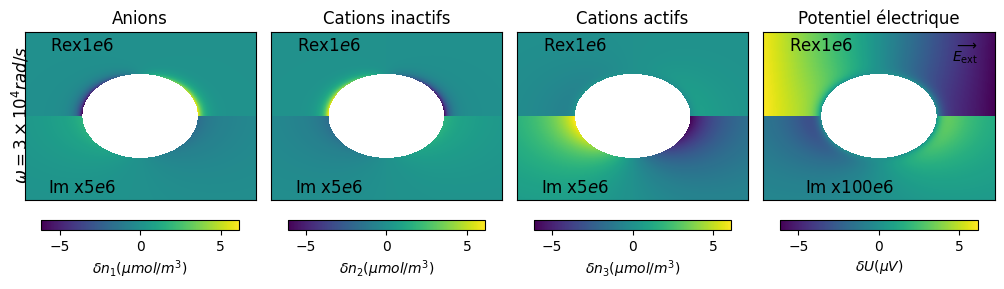

In [67]:
import matplotlib.pyplot as plt
###############################
omega = 3e4 # rad/s
################################


# Je recupère les coefficients de la solution générale

E_w = E_omega(omega)
A_w= A_omega(E_w, omega)
M_w = M_omega(E_w)
B_w = B_omega(E_w)

#Calcul des concentrations et le potentiel sur chaque point de la grid 
concentration_n_1= dn_1(r,theta, omega)
concentration_n_2= dn_2(A_w, B_w, M_w,theta)
concentration_n_3 = dn_3(A_w, M_w, theta )
potential_values = dU(r, theta, omega)

# Initialisation des valeurs à NaN
# Le code crée un tableau de donnée de même taille que la concentration_n_1.real et les rempli de nan
concentration_combined1 = np.full_like(concentration_n_1.real, np.nan)
concentration_combined2 = np.full_like(concentration_n_2.real, np.nan)
concentration_combined3 = np.full_like(concentration_n_3.real, np.nan)
concentration_combined4 = np.full_like(potential_values.real, np.nan)

# Appliquer le masque
concentration_n_1.real[mask]=np.nan
concentration_n_1.imag[mask]=np.nan
concentration_n_2.real[mask]=np.nan
concentration_n_2.imag[mask]=np.nan
concentration_n_3.real[mask]=np.nan
concentration_n_3.imag[mask]=np.nan
potential_values.real[mask] =np.nan
potential_values.imag[mask] =np.nan

# Assignation des valeurs réelles et imaginaires
concentration_combined1[mask_upper ] = concentration_n_1.real[mask_upper ] *1e6
concentration_combined1[mask_lower ] = concentration_n_1.imag[mask_lower ] *5e6


# Assignation des valeurs réelles et imaginaires
concentration_combined2[mask_upper ] = concentration_n_2.real[mask_upper ] *1e6
concentration_combined2[mask_lower ] = concentration_n_2.imag[mask_lower ] *5e6

# Assignation des valeurs réelles et imaginaires
concentration_combined3[mask_upper ] = concentration_n_3.real[mask_upper ] *1e6
concentration_combined3[mask_lower ] = concentration_n_3.imag[mask_lower ] *5e6

# Assignation des valeurs réelles et imaginaires
concentration_combined4[mask_upper ] = potential_values.real.real[mask_upper ]*1e6 
concentration_combined4[mask_lower ] = potential_values.imag[mask_lower ] * 100e6

##
# Création de la figure avec une grille de 1x4 sous-graphiques
fig, axs = plt.subplots(1, 4, figsize=(10, 3))  # Adjusted figsize for better spacing

# Premier sous-graphe
c1 = axs[0].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined1,
     cmap="viridis"
    # vmin=-2.5,
    # vmax=2.5,
)

cbar1 = fig.colorbar(c1, ax=axs[0], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_1 (\mu mol/m^3)$", labelpad=3)
axs[0].set_title("Anions")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[0].text(-1*1e-7 , -1.7*1e-7, 'Im x$5e6$', fontsize=12, ha='center', va='center', color='black')

# Deuxième sous-graphe
c2 = axs[1].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined2,
    cmap="viridis"
    # vmin=-2.5,
    # vmax=2.5,
)
cbar1 = fig.colorbar(c1, ax=axs[1], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_2 (\mu mol/m^3)$", labelpad=3)
axs[1].set_title("Cations inactifs")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[1].text(-1*1e-7 , -1.7*1e-7, 'Im x$5e6$', fontsize=12, ha='center', va='center', color='black')

# Troisième sous-graphe
c3 = axs[2].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined3,
    cmap="viridis"
    # vmin=-0.25,
    # vmax=0.25,
)
cbar1 = fig.colorbar(c1, ax=axs[2], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_3 (\mu mol/m^3)$", labelpad=3)
axs[2].set_title("Cations actifs")
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[2].text(-1*1e-7 , -1.7*1e-7, 'Im x$5e6$', fontsize=12, ha='center', va='center', color='black')

# Quatrième sous-graphe
c4 = axs[3].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined4,
    cmap="viridis"
    # vmin=-0.2,
    # vmax=0.2,
)
cbar1 = fig.colorbar(c1, ax=axs[3], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta U (\mu V)$", labelpad=3)
axs[3].set_title("Potentiel électrique")
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[3].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[3].text(-0.5*1e-7 , -1.7*1e-7, 'Im x$100e6$', fontsize=12, ha='center', va='center', color='black')
axs[3].text(1.5*1e-7 , 1.7*1e-7, r'$\longrightarrow$', fontsize=10, ha='center', va='center', color='black')
axs[3].text(1.5*1e-7 , 1.4*1e-7, r'$E_{\text{ext}}$', fontsize=10, ha='center', va='center', color='black')

fig.text(0.0005, 0.6, r'$\omega = 3\times 10^4 rad/s$', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste les marges pour faire plus de place au label
plt.savefig("perturbation1.png")
plt.tight_layout()
plt.show()


# Plot utilisant la fréquence angulaire $\omega= 3e6~~ rad/s$

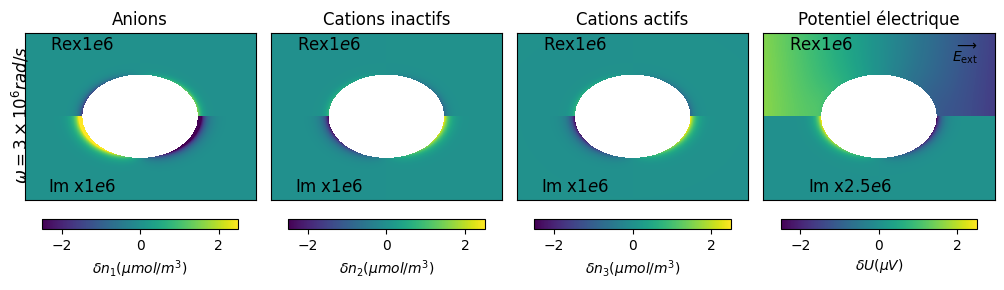

In [68]:
import matplotlib.pyplot as plt
###############################
omega = 3e6 # rad/s
################################


#Calcul des concentrations et le potentiel sur chaque point de la grid 
concentration_n_1= dn_1(r,theta, omega)
concentration_n_2= dn_2(A_w, B_w, M_w,theta)
concentration_n_3 = dn_3(A_w, M_w, theta )
potential_values = dU(r, theta, omega)

# Initialisation des valeurs à NaN
concentration_combined1 = np.full_like(concentration_n_1.real, np.nan)
concentration_combined2 = np.full_like(concentration_n_2.real, np.nan)
concentration_combined3 = np.full_like(concentration_n_3.real, np.nan)
concentration_combined4 = np.full_like(potential_values.real, np.nan)

# Appliquer le masque
concentration_n_1.real[mask]=np.nan
concentration_n_1.imag[mask]=np.nan
concentration_n_2.real[mask]=np.nan
concentration_n_2.imag[mask]=np.nan
concentration_n_3.real[mask]=np.nan
concentration_n_3.imag[mask]=np.nan
potential_values.real[mask] =np.nan
potential_values.imag[mask] =np.nan

# Assignation des valeurs réelles et imaginaires
concentration_combined1[mask_upper ] = concentration_n_1.real[mask_upper ] *1e6
concentration_combined1[mask_lower ] = concentration_n_1.imag[mask_lower ] *1e6


# Assignation des valeurs réelles et imaginaires
concentration_combined2[mask_upper ] = concentration_n_2.real[mask_upper ] *1e6
concentration_combined2[mask_lower ] = concentration_n_2.imag[mask_lower ] *1e6

# Assignation des valeurs réelles et imaginaires
concentration_combined3[mask_upper ] = concentration_n_3.real[mask_upper ] *1e6
concentration_combined3[mask_lower ] = concentration_n_3.imag[mask_lower ] *1e6

# Assignation des valeurs réelles et imaginaires
concentration_combined4[mask_upper ] = potential_values.real.real[mask_upper ]*1e6 
concentration_combined4[mask_lower ] = potential_values.imag[mask_lower ] * 2.5e6

##
# Création de la figure avec une grille de 1x4 sous-graphiques
fig, axs = plt.subplots(1, 4, figsize=(10, 3))  # Adjusted figsize for better spacing

# Premier sous-graphe
c1 = axs[0].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined1,
    cmap="viridis",
    vmin=-2.5,
    vmax=2.5,
)
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[0], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_1 (\mu mol/m^3)$")
axs[0].set_title("Anions")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[0].text(-1*1e-7 , -1.7*1e-7, 'Im x$1e6$', fontsize=12, ha='center', va='center', color='black')

# Deuxième sous-graphe
c2 = axs[1].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined2,
    cmap="viridis"
    # vmin=-2.5,
    # vmax=2.5,
)
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[1], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_2 (\mu mol/m^3)$")
axs[1].set_title("Cations inactifs")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[1].text(-1*1e-7 , -1.7*1e-7, 'Im x$1e6$', fontsize=12, ha='center', va='center', color='black')

# Troisième sous-graphe
c3 = axs[2].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined3,
    cmap="viridis"
#     vmin=-0.25,
#     vmax=0.25,
)
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[2], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_3 (\mu mol/m^3)$")
axs[2].set_title("Cations actifs")
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[2].text(-1*1e-7 , -1.7*1e-7, 'Im x$1e6$', fontsize=12, ha='center', va='center', color='black')

# Quatrième sous-graphe
c4 = axs[3].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined4,
    cmap="viridis"
    # vmin=-0.2,
    # vmax=0.2,
)
cbar1 = fig.colorbar(c1, ax=axs[3], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta U (\mu V)$", labelpad=3)
# fig.colorbar(c4, ax=axs[3], label="$\delta n_2(\mathbf{r}, \omega)$")
axs[3].set_title("Potentiel électrique")
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[3].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[3].text(-0.5*1e-7 , -1.7*1e-7, 'Im x$2.5e6$', fontsize=12, ha='center', va='center', color='black')
axs[3].text(1.5*1e-7 , 1.7*1e-7, r'$\longrightarrow$', fontsize=10, ha='center', va='center', color='black')
axs[3].text(1.5*1e-7 , 1.4*1e-7, r'$E_{\text{ext}}$', fontsize=10, ha='center', va='center', color='black')

# Ajouter le texte vertical sur le côté gauche
fig.text(0.0005, 0.6, r'$\omega = 3\times 10^6 rad/s$', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste les marges pour faire plus de place au label
plt.savefig("perturbation2.png")
plt.tight_layout()

plt.show()


# Plot utilisant la fréquence angulaire $\omega= 3e8~~rad/s$

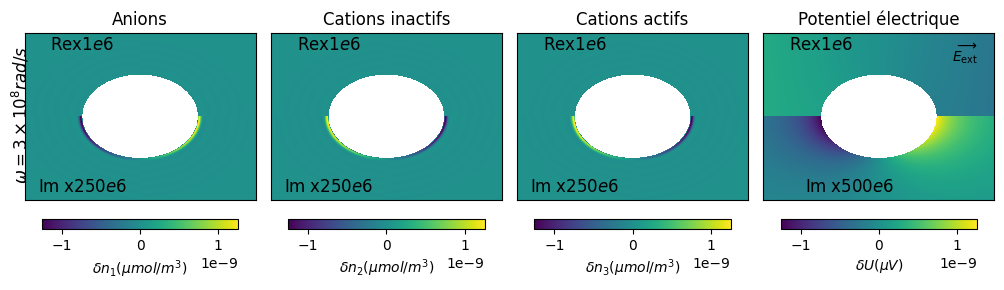

In [49]:
import matplotlib.pyplot as plt
###############################
omega = 3e8 # rad/s
################################

#Calcul des concentrations et le potentiel sur chaque point de la grid 
concentration_n_1= dn_1(r,theta, omega)
concentration_n_2= dn_2(A_w, B_w, M_w,theta)
concentration_n_3 = dn_3(A_w, M_w, theta )
potential_values = dU(r, theta, omega)

# Initialisation des valeurs à NaN
concentration_combined1 = np.full_like(concentration_n_1.real, np.nan)
concentration_combined2 = np.full_like(concentration_n_2.real, np.nan)
concentration_combined3 = np.full_like(concentration_n_3.real, np.nan)
concentration_combined4 = np.full_like(potential_values.real, np.nan)

# Appliquer le masque
concentration_n_1.real[mask]=np.nan
concentration_n_1.imag[mask]=np.nan
concentration_n_2.real[mask]=np.nan
concentration_n_2.imag[mask]=np.nan
concentration_n_3.real[mask]=np.nan
concentration_n_3.imag[mask]=np.nan
potential_values.real[mask] =np.nan
potential_values.imag[mask] =np.nan

# Assignation des valeurs réelles et imaginaires
concentration_combined1[mask_upper ] = concentration_n_1.real[mask_upper ] *1e6
concentration_combined1[mask_lower ] = concentration_n_1.imag[mask_lower ]  * 250e6


# Assignation des valeurs réelles et imaginaires
concentration_combined2[mask_upper ] = concentration_n_2.real[mask_upper ] *1e6
concentration_combined2[mask_lower ] = concentration_n_2.imag[mask_lower ] * 250e6


# Assignation des valeurs réelles et imaginaires
concentration_combined3[mask_upper ] = concentration_n_3.real[mask_upper ] *1e6
concentration_combined3[mask_lower ] = concentration_n_3.imag[mask_lower ] * 250e6

# Assignation des valeurs réelles et imaginaires
concentration_combined4[mask_upper ] = potential_values.real.real[mask_upper ]*1e6 
concentration_combined4[mask_lower ] = potential_values.imag[mask_lower ] * 500e6

##
# Création de la figure avec une grille de 1x4 sous-graphiques
fig, axs = plt.subplots(1, 4, figsize=(10, 3))  # Adjusted figsize for better spacing

# Premier sous-graphe
c1 = axs[0].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined1,
    cmap="viridis"
)
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[0], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_1 (\mu mol/m^3)$")
# cbar1.set_ticks([-2.5, 0, 2.5])
# fig.colorbar(c1, ax=axs[0], label="$\delta n_3(\mathbf{r}, \omega)$")
axs[0].set_title("Anions")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[0].text(-1*1e-7 , -1.7*1e-7, 'Im x$250e6$', fontsize=12, ha='center', va='center', color='black')

# Deuxième sous-graphe
c2 = axs[1].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined2,
    cmap="viridis"
)
# fig.colorbar(c2, ax=axs[1], label="$\delta n_3(\mathbf{r}, \omega)$")
axs[1].set_title("Cations inactifs")
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[1], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_2 (\mu mol/m^3)$", labelpad=3)
# cbar1.set_ticks([-2.5, 0, 2.5])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[1].text(-1*1e-7 , -1.7*1e-7, 'Im x$250e6$', fontsize=12, ha='center', va='center', color='black')

# Troisième sous-graphe
c3 = axs[2].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined3,
    cmap="viridis"
)
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[2], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta n_3 (\mu mol/m^3)$", labelpad=3)
# cbar1.set_ticks([-0.25,0, 0.25])
#  Assurer que les limites de la barre de couleur sont correctes
# cbar1.ax.set_xlim(-2, 2)

axs[2].set_title("Cations actifs")
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[2].text(-1*1e-7 , -1.7*1e-7, 'Im x$250e6$', fontsize=12, ha='center', va='center', color='black')

# Quatrième sous-graphe
c4 = axs[3].pcolormesh(
    x_grid,
    y_grid,
    concentration_combined4,
    cmap="viridis"
)
# Ajuster la barre de couleur
cbar1 = fig.colorbar(c1, ax=axs[3], orientation='horizontal', pad=0.1, fraction=0.05)
cbar1.set_label("$\delta U (\mu V)$", labelpad=3)
# cbar1.set_ticks([-0.2, 0, 0.2])
# Assurer que les limites de la barre de couleur sont correctes
# cbar1.ax.set_xlim(-0.2,0.2)
# fig.colorbar(c4, ax=axs[3], label="$\delta n_2(\mathbf{r}, \omega)$")
axs[3].set_title("Potentiel électrique")
axs[3].set_xticks([])
axs[3].set_yticks([])
# Ajouter le texte vertical sur le côté gauche
fig.text(0.0005, 0.6, r'$\omega = 3\times 10^8 rad/s$', va='center', rotation='vertical', fontsize=12)
axs[3].text(-1*1e-7 , 1.7*1e-7, 'Rex$1e6$', fontsize=12, ha='center', va='center', color= 'black')
axs[3].text(-0.5*1e-7 , -1.7*1e-7, 'Im x$500e6$', fontsize=12, ha='center', va='center', color='black')
axs[3].text(1.5*1e-7 , 1.7*1e-7, r'$\longrightarrow$', fontsize=10, ha='center', va='center', color='black')
axs[3].text(1.5*1e-7 , 1.4*1e-7, r'$E_{\text{ext}}$', fontsize=10, ha='center', va='center', color='black')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste les marges pour faire plus de place au label


plt.savefig("perturbation3.png")
plt.tight_layout()
plt.show()
